In [30]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline 
pd.set_option('display.max_colwidth',200)  

In [31]:
def read_text(filename):
  file= open(filename,mode='rt',encoding='utf-8')
  text = file.read()
  file.close()
  return text

In [32]:
#split a text into sentences
def to_lines(text):
  sents = text.strip().split('\n')
  sents = [i.split('\t') for i in sents]
  return sents

In [33]:
data = read_text("/content/deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [34]:
deu_eng = deu_eng[:50000,:]

In [35]:
#let's take a look at our data
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['We took a wrong turn.', 'Wir sind falsch abgebogen.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #823901 (jellorage) & #2112094 (freddy1)'],
       ['We traveled together.', 'Wir waren zusammen auf Reisen.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1582121 (Spamster) & #1600396 (Pfirsichbaeumchen)'],
       ['We traveled together.', 'Wir sind zusammen gereist.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1582121 (Spamster) & #1600398 (Pfirsichbaeumchen)']],
      dtype='<U537')

In [36]:
eng_l = []
deu_l = []

#populate the lists with sentence length
for i in deu_eng[:,0]:
  eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
  deu_l.append(len(i.split()))

In [37]:
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l}) 

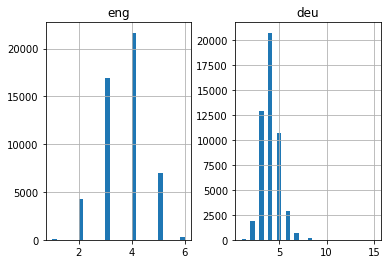

In [38]:
length_df.hist(bins =30)
plt.show()

In [39]:
#function to build a tokenizer
def tokenization(lines):
  tokenizer =Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

In [40]:
#prepare to build tokenizer
eng_tokenizer = tokenization(deu_eng[:,0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6150


In [41]:
deu_tokenizer = tokenization(deu_eng[:,1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10119


In [42]:
def encode_sequences(tokenizer, length, lines):
  seq = tokenizer.texts_to_sequences(lines)
  seq = pad_sequences(seq, maxlen=length, padding='post')
  return seq

In [43]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [44]:

trainX =encode_sequences(deu_tokenizer, deu_length, train[:,1]) 
trainY =encode_sequences(eng_tokenizer, eng_length, train[:,0])

In [45]:

testX =encode_sequences(deu_tokenizer, deu_length, test[:,1]) 
testY =encode_sequences(eng_tokenizer, eng_length, test[:,0])

In [46]:
#build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
  model = Sequential()
  model.add(Embedding(in_vocab, units, input_length= in_timesteps, mask_zero= True))
  model.add(LSTM(units))
  model.add(RepeatVector(out_timesteps))
  model.add(LSTM(units, return_sequences= True))
  model.add(Dense(out_vocab, activation='softmax'))
  return model


In [47]:
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [52]:
filename = 'model.h1.24_Unnati'
checkpoint = ModelCheckpoint(filename, monitor='val_loss' , verbose=1, save_best_only=True,mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
          epochs=5, batch_size=512,
          validation_split= 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/5
63/63 [==============================] - 198s 3s/step - loss: 4.2658 - val_loss: 2.7933

Epoch 00001: val_loss improved from inf to 2.79326, saving model to model.h1.24_Unnati


INFO:tensorflow:Assets written to: model.h1.24_Unnati/assets


INFO:tensorflow:Assets written to: model.h1.24_Unnati/assets


Epoch 2/5
63/63 [==============================] - 172s 3s/step - loss: 2.7164 - val_loss: 2.6723

Epoch 00002: val_loss improved from 2.79326 to 2.67231, saving model to model.h1.24_Unnati


INFO:tensorflow:Assets written to: model.h1.24_Unnati/assets


INFO:tensorflow:Assets written to: model.h1.24_Unnati/assets


Epoch 3/5
63/63 [==============================] - 168s 3s/step - loss: 2.5625 - val_loss: 2.4939

Epoch 00003: val_loss improved from 2.67231 to 2.49386, saving model to model.h1.24_Unnati


INFO:tensorflow:Assets written to: model.h1.24_Unnati/assets


INFO:tensorflow:Assets written to: model.h1.24_Unnati/assets


Epoch 4/5
63/63 [==============================] - 168s 3s/step - loss: 2.3811 - val_loss: 2.3703

Epoch 00004: val_loss improved from 2.49386 to 2.37029, saving model to model.h1.24_Unnati


INFO:tensorflow:Assets written to: model.h1.24_Unnati/assets


INFO:tensorflow:Assets written to: model.h1.24_Unnati/assets


Epoch 5/5
63/63 [==============================] - 169s 3s/step - loss: 2.2416 - val_loss: 2.2551

Epoch 00005: val_loss improved from 2.37029 to 2.25514, saving model to model.h1.24_Unnati


INFO:tensorflow:Assets written to: model.h1.24_Unnati/assets


INFO:tensorflow:Assets written to: model.h1.24_Unnati/assets


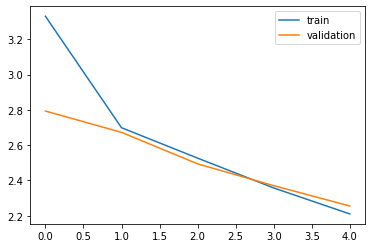

In [66]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [78]:
model = load_model('model.h1.24_Unnati')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [80]:
def get_word(n, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == n:
      return word
      return None

In [91]:
#convert predictions into text (English)
preds_text = []
for i in preds:
  temp= []
  for j in range(len(i)):
    t = get_word(i[j], eng_tokenizer)
    if j > 0:
        if (t== get_word(i[j-1],eng_tokenizer)) or (t == None):
            temp.append('')
        else:
          temp.append(t)

    else:
        if(t== None):
            temp.append('')
        else:
             temp.append(t)

  preds_text.append(' '.join(temp))

In [93]:
pred_df = pd.DataFrame({'actual' : test[:,0], ' predicted' : preds_text})

In [95]:
pd.set_option('display.max_colwidth', 200)

In [96]:
pred_df.head(15)

,actual,predicted
0,What is the number?,please your the
1,Try it on.,don't you
2,We were wrong.,we not tom
3,That's untrue.,it you
4,Don't touch anything.,please it
5,Tom is calling back.,tom was a
6,I think Tom is awake.,i have tom
7,What are you having?,how i you
8,I like that flag.,i don't to
9,You have a good job.,you a


In [97]:
pred_df.tail(15)

,actual,predicted
9985,I saw you looking.,i have tom
9986,Tom was so busy.,tom has a
9987,Where could he be?,he did tom
9988,My friend was shot.,my a
9989,"Come on, trust me.",do you
9990,Life is too short.,it's a
9991,Everybody saw it.,tom
9992,Try harder.,what me
9993,He will be punished.,he was a
9994,I speak Swedish.,i am
